### LSTM System Identification

Name: Ananda Cahyo Wibowo<br />
NRP : 07111940000128 <br />
Undergrad Thesis Title : Data Driven Gas Lift Well And Network Optimization With Neural Network Based System Identification Using Modbus Simulator

Data Preparation

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#Read the csv file
df = pd.read_csv("upsample_min.csv")
df = pd.read_csv("upsample.csv")
df = pd.read_csv("upsampled_matlab_nonrevised.csv")
df = pd.read_csv("upsampled_matlab.csv")
#df = pd.read_csv("upsampled_matlab_revv.csv")
df = pd.read_csv("upsampled_matlab_zoh.csv")
df = pd.read_csv("upsampled_matlab_zoh3.csv")
df = pd.read_csv("upsampled_matlab_zoh2.csv")
#df = pd.read_csv("upsampled_matlab_foh.csv")
#df = pd.read_csv("upsampled_matlab_foh2.csv")
#df = pd.read_csv("upsampled_matlab_renew.csv")
df2=df.drop(df.columns[0], axis=1)
data = df['glir11'].to_numpy()

split = 0.6
epoch = 50
batchsize = 14
filename = "RNN_qo_type9_" + f"{epoch}+{batchsize}" 

x1 = df['glir11'].to_numpy()[:int(split*len(data))]
x1 = x1.reshape(len(x1),1)
y1 = df['qo11'].to_numpy()[:int(split*len(data))]
y1 = y1.reshape(len(y1),1)

"""x1 = df['glir11'].to_numpy()[:]
x1 = x1.reshape(len(x1),1)
y1 = df['qo11'].to_numpy()[:]
y1 = y1.reshape(len(y1),1)"""

x2 = df['glir11'].to_numpy()[int(split*len(data)):]
y2 = df['qo11'].to_numpy()[int(split*len(data)):]

print(f"ukuran x train: {np.shape(x1)} ukuran y train: {np.shape(y1)}")
print(f"ukuran x test: {np.shape(x2)} ukuran y test: {np.shape(y2)}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ukuran x train: (8694, 1) ukuran y train: (8694, 1)
ukuran x test: (5797,) ukuran y test: (5797,)


In [2]:
df.describe()

,index,glir11,qo11,qt11,wc11,glir22,qo22,qt22,wc22
count,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,1.449100e+04,1.449100e+04,1.449100e+04
mean,7446.331930,1804.490511,209.102964,302.813407,9.048547,1262.490511,7.648858e+01,1.237258e+02,5.061822e+00
std,4197.909251,1336.645277,61.632613,119.737729,8.492933,1336.645277,6.414332e+01,1.197157e+02,8.492704e+00
min,1.000000,542.000000,0.000000,0.000000,0.000000,0.000000,-3.400000e-12,-7.870000e-13,-3.620000e-13
25%,3832.500000,560.000000,144.280000,191.220000,3.987000,18.000000,1.028000e+01,1.212000e+01,0.000000e+00
50%,7455.000000,1422.000000,208.000000,269.800000,5.153181,880.000000,7.400000e+01,9.070000e+01,1.166181e+00
75%,11077.500000,2701.000000,247.000000,366.820000,10.987093,2159.000000,1.177200e+02,1.877200e+02,7.000093e+00
max,14700.000000,6252.000000,382.370000,754.850000,56.987359,5710.000000,2.955700e+02,5.757500e+02,5.300036e+01


Text(0.5, 1.0, 'data distribution: mean=2012.18, std dev=1372.73')

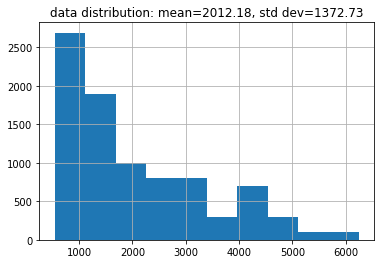

In [2]:
dataa = x1
plt.hist(dataa,bins=10)
plt.grid()
plt.title(f"data distribution: mean={round(np.mean(dataa),2)}, std dev={round(np.std(dataa),2)}")

Text(0.5, 1.0, 'Training Dataset')

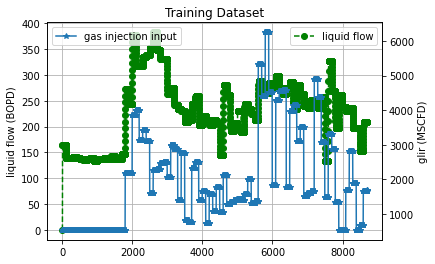

In [3]:
fig, ax_left = plt.subplots()
ax_left.plot(list(range(len(y1))),y1,'--go', label = 'liquid flow')
ax_left.set_ylabel('liquid flow (BOPD)')

ax_right = ax_left.twinx()
ax_right.plot(list(range(len(x1))),x1,'-*',label = 'gas injection input')
ax_right.set_ylabel('glir (MSCFD)')
ax_left.legend()
ax_right.legend()
ax_left.grid()
plt.title("Training Dataset")

Text(0.5, 1.0, 'Testing Dataset')

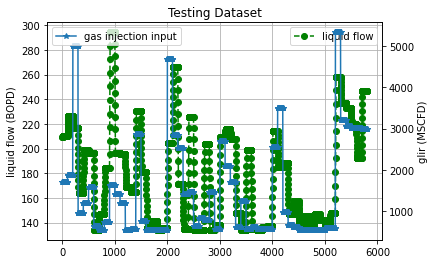

In [4]:
fig, ax_left = plt.subplots()
ax_left.plot(list(range(len(y2))),y2,'--go', label = 'liquid flow')
ax_left.set_ylabel('liquid flow (BOPD)')

ax_right = ax_left.twinx()
ax_right.plot(list(range(len(x2))),x2,'-*',label = 'gas injection input')
ax_right.set_ylabel('glir (MSCFD)')
ax_left.legend()
ax_right.legend()
ax_left.grid()
plt.title("Testing Dataset")

## Train Data

Preprocessing Data

In [5]:
#New dataframe with only training data
df_for_training_x = x1
df_for_training_y = y1

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training_x)
scaler2 = scaler.fit(df_for_training_y)
df_for_training_scaled_x = scaler.transform(df_for_training_x)
df_for_training_scaled_y = scaler2.transform(df_for_training_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled_x) - n_future +1):
    trainX.append(df_for_training_scaled_x[i - n_past:i, 0:df_for_training_x.shape[1]])

for i in range(n_past, len(df_for_training_scaled_y) - n_future +1):
    trainY.append(df_for_training_scaled_y[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (8680, 14, 1).
trainY shape == (8680, 1).


RNN LSTM Architecture & Training

In [6]:
# define the Autoencoder model

model = Sequential()
"""model.add(SimpleRNN(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(SimpleRNN(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(SimpleRNN(32, activation='relu', return_sequences=False))"""
model.add(LSTM(14, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(7, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.summary("")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 14)            896       
                                                                 
 lstm_1 (LSTM)               (None, 7)                 616       
                                                                 
 dropout (Dropout)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 1,520
Trainable params: 1,520
Non-trainable params: 0
_________________________________________________________________


In [7]:
# fit the model
history = model.fit(trainX, trainY, epochs=epoch, batch_size=batchsize, validation_split=0.1, verbose=1)

Epoch 1/50
558/558 [==============================] - 4s 5ms/step - loss: 0.7592 - mse: 0.7592 - mae: 0.6215 - mape: 220.8963 - val_loss: 0.7081 - val_mse: 0.7081 - val_mae: 0.7031 - val_mape: 554.7720
Epoch 2/50
558/558 [==============================] - 3s 5ms/step - loss: 0.4663 - mse: 0.4663 - mae: 0.4997 - mape: 297.1981 - val_loss: 0.8135 - val_mse: 0.8135 - val_mae: 0.7950 - val_mape: 542.0980
Epoch 3/50
558/558 [==============================] - 3s 5ms/step - loss: 0.4187 - mse: 0.4187 - mae: 0.4843 - mape: 325.9992 - val_loss: 0.9409 - val_mse: 0.9409 - val_mae: 0.8278 - val_mape: 581.4102
Epoch 4/50
558/558 [==============================] - 3s 5ms/step - loss: 0.4045 - mse: 0.4045 - mae: 0.4739 - mape: 312.4257 - val_loss: 0.7224 - val_mse: 0.7224 - val_mae: 0.7737 - val_mape: 641.9775
Epoch 5/50
558/558 [==============================] - 3s 5ms/step - loss: 0.3869 - mse: 0.3869 - mae: 0.4662 - mape: 311.7873 - val_loss: 0.8353 - val_mse: 0.8353 - val_mae: 0.8014 - val_mape:

In [8]:
model.save(filename)

INFO:tensorflow:Assets written to: RNN_qo_type9_50+14\assets


INFO:tensorflow:Assets written to: RNN_qo_type9_50+14\assets


In [9]:
#from tensorflow.keras.models import load_model
#model = load_model("RNN_model_resolved")

Weights and Biasses

In [10]:
"""layers = list(np.arange(0,3)) #[0,1,2,4] #layer 0:lstm 1:lstm 3:dense
layers.pop(-2)

weights = {}
biases = {}
for layer in layers:
    weights[layer] = model.layers[layer].get_weights()[0]
    biases[layer] = model.layers[layer].get_weights()[1]

nlayer = 1
print(np.shape(weights[nlayer]))
print(weights[nlayer])

print(np.shape(biases[nlayer]))
print(biases[nlayer])"""

'layers = list(np.arange(0,3)) #[0,1,2,4] #layer 0:lstm 1:lstm 3:dense\nlayers.pop(-2)\n\nweights = {}\nbiases = {}\nfor layer in layers:\n    weights[layer] = model.layers[layer].get_weights()[0]\n    biases[layer] = model.layers[layer].get_weights()[1]\n\nnlayer = 1\nprint(np.shape(weights[nlayer]))\nprint(weights[nlayer])\n\nprint(np.shape(biases[nlayer]))\nprint(biases[nlayer])'

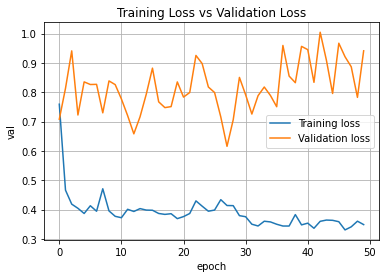

In [11]:
xx = np.arange(0,len(history.history['loss']))

"""print(history.history['loss'])
print(history.history['val_loss'])
print(xx)"""

plt.figure(1)
plt.plot(xx,history.history['loss'], label='Training loss')
plt.plot(xx,history.history['val_loss'], label='Validation loss')
plt.title("Training Loss vs Validation Loss")
plt.xlabel("epoch")
plt.ylabel("val")
plt.legend()
plt.grid()

Predicting Values

272/272 [==============================] - 1s 2ms/step
nilai pred: [[150.84174]
 [150.84174]
 [150.84174]
 ...
 [255.1907 ]
 [255.42346]
 [256.8925 ]]
ukuran y: (8680, 1) ukuran y pred: (8680, 1)


<Figure size 432x288 with 0 Axes>

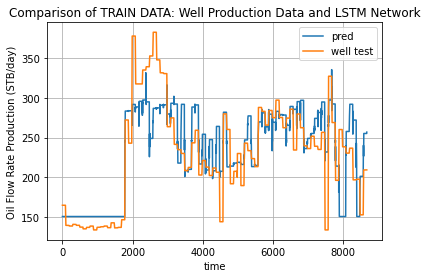

In [12]:
#Make prediction
#model = keras.models.load_model("RNN_Model")

n_days_for_prediction = 20
prediction = model.predict(trainX[:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_for_training_y.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)

print('nilai pred:',y_pred_future)

yy = scaler.inverse_transform(trainY)

x_axis = np.arange(0,y_pred_future.shape[0])

print(f"ukuran y: {np.shape(yy)} ukuran y pred: {np.shape(y_pred_future)}")

plt.figure(2)


fig, ax_left = plt.subplots()
ax_left.plot(x_axis,y_pred_future[:], label='pred')
ax_left.plot(x_axis,yy, label='well test')
ax_left.legend()
ax_left.set_ylabel('liquid flow (BOPD)')

"""ax_right = ax_left.twinx()
ax_right.plot(x_axis,x1[14:], '--*g', label='GLIR')
ax_right.set_ylabel('liquid flow (BOPD)')"""

#plt.plot(x_axis,y_pred_future, label='pred')
#plt.plot(x_axis,yy, label='well test')
plt.title("Comparison of TRAIN DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

Metric

In [13]:
model.metrics_names

['loss', 'mse', 'mae', 'mape']

Root Mean Square Error:
37.78

R2 Value:
0.66
272/272 [==============================] - 1s 3ms/step - loss: 0.3435 - mse: 0.3435 - mae: 0.4329 - mape: 399.1483

Score:
[0.3435172438621521, 0.3435172438621521, 0.4329363703727722, 399.1483154296875]


Text(0.5, 1.0, 'R2 Score= 0.66 of Training data')

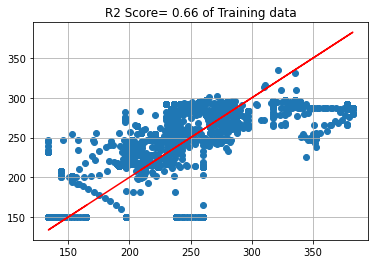

In [14]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yy,y_pred_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(round(RMSE,2))

r2 = r2_score(yy,y_pred_future)
print("\nR2 Value:")
print(round(r2,2))

score = model.evaluate(trainX,trainY)
print("\nScore:")
print(score)

plt.scatter(yy,y_pred_future)
plt.plot(yy,yy,'r')
plt.grid()
#plt.plot(y_fore_future,y_fore_future)
plt.title(f"R2 Score= {round(r2,2)} of Training data")

## Forecasting Value/Test Data

In [15]:
from tensorflow.keras.models import load_model
#model = load_model("RNN_model_resolved_bagus_0.6r1") #BAGUSSSSSS
#model = load_model("RNN_model_resolved100")
#model = load_model("RNN_model_resolved_bagus_udahdicoba")
#model = load_model("RNN_qo_type3_5+14")
#model = load_model("RNN_qo_type7_100+14")
#df2 = pd.read_csv("upsample.csv")
#df2 = df2.iloc[:,0:152]
x2 = df['glir11'].to_numpy()[int(split*len(data)):]
y2 = df['qo11'].to_numpy()[int(split*len(data)):]

#x2 = df['glir11'].to_numpy()[:]
#y2 = df['qo11'].to_numpy()[:]

#New dataframe with only testing data
x2 = x2.reshape(len(x2),1)
y2 = y2.reshape(len(y2),1)
df_for_testing_x = x2
df_for_testing_y = y2

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing_x)
scaler2 = scaler.fit(df_for_testing_y)

df_for_testing_scaled_x = scaler.transform(df_for_testing_x)
df_for_testing_scaled_y = scaler2.transform(df_for_testing_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for testing). 

#Empty lists to be populated using formatted testing data
testX = []
testY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_testing_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_testing_scaled_x) - n_future +1):
    testX.append(df_for_testing_scaled_x[i - n_past:i, 0:df_for_testing_x.shape[1]])

for i in range(n_past, len(df_for_testing_scaled_y) - n_future +1):
    testY.append(df_for_testing_scaled_y[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (5783, 14, 1).
testY shape == (5783, 1).


181/181 [==============================] - 0s 2ms/step
ukuran y: (5783, 1) ukuran y pred: (5783, 1)


<Figure size 432x288 with 0 Axes>

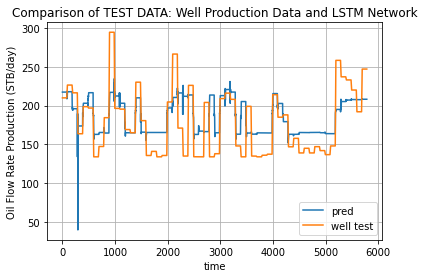

In [16]:
#Make forecast
#model = keras.models.load_model("RNN_Model")

n_days_for_forecast = 20
forecast = model.predict(testX[:]) #shape = (n, 1) where n is the n_days_for_forecast

#Perform inverse transformation to rescale back to original range

forecast_copies = np.repeat(forecast, df_for_testing_y.shape[1], axis=-1)
y_fore_future = scaler.inverse_transform(forecast_copies)

#print('nilai pred:',y_fore_future)

yyy = scaler.inverse_transform(testY[:])

x_axis = np.arange(0,y_fore_future.shape[0])

print(f"ukuran y: {np.shape(yyy)} ukuran y pred: {np.shape(y_fore_future)}")

plt.figure(2)

fig, ax_left = plt.subplots()
ax_left.plot(x_axis,y_fore_future,label='pred')
ax_left.plot(x_axis,yyy, label='well test')
ax_left.legend()
ax_left.set_ylabel('liquid flow (BOPD)')

#ax_right = ax_left.twinx()
#ax_right.plot(x_axis,np.subtract(yyy,y_fore_future),'--r',label='error')
"""ax_right.plot(x_axis,x2[14:], '--*g', label='GLIR')
ax_right.set_ylabel('liquid flow (BOPD)')"""


#plt.plot(x_axis,y_fore_future,label='pred')
#plt.plot(x_axis,yyy, label='well test')
#plt.plot(x_axis,x2[14:], label='well test')
plt.title("Comparison of TEST DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

Metric

Root Mean Square Error:
30.86

R2 Value:
0.43
181/181 [==============================] - 0s 2ms/step - loss: 0.5726 - mse: 0.5726 - mae: 0.6040 - mape: 97.2587

Score:
[0.5726250410079956, 0.5726250410079956, 0.6040459275245667, 97.25865936279297]


Text(0.5, 1.0, 'R2 Score= 0.43 of Forecasting data')

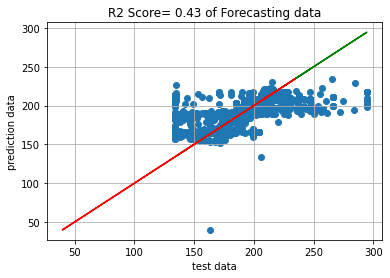

In [17]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yyy,y_fore_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(round(RMSE,2))

r2 = r2_score(yyy,y_fore_future)
print("\nR2 Value:")
print(round(r2,2))

score = model.evaluate(testX,testY)
print("\nScore:")
print(score)

plt.scatter(yyy,y_fore_future)
plt.plot(yyy,yyy,'g',label='test')
plt.plot(y_fore_future,y_fore_future,'r',label='pred')
plt.grid()
plt.xlabel("test data")
plt.ylabel("prediction data")
#plt.plot(y_fore_future,y_fore_future)
plt.title(f"R2 Score= {round(r2,2)} of Forecasting data")

### Test in the looping

In [18]:
"""import numpy as np
import random
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

#model = load_model("RNN_model_resolved100")
input = []
output = []
i = 0
n_past = 14
input_init = []
forecasting = []
while True:
    if i < n_past:
        ran = random.randint(600,2000)
        input_init.append(ran)
        input_zero = np.zeros((n_past-(i+1),))
        input_zero = input_zero.tolist()

        input_totall = input_init + input_zero
        print('VALUES',input_totall,'type',np.shape(input_totall))
        input_total = np.array(input_totall)
        input_total = np.reshape(input_total,(1,n_past,1))

        forecastt = model.predict(input_total) #shape = (n, 1) where n is the n_days_for_forecast
        forecastt = forecastt.tolist()[0][0]
        forecasting.append(forecastt)

        fig, ax_left = plt.subplots()
        ax_left.plot(list(range(len(forecasting))),forecasting,'-go', label = 'well pred')
        ax_left.set_ylabel('well pred')

        ax_right = ax_left.twinx()
        ax_right.plot(list(range(len(input_total[0,:,:]))),input_total[0,:,:], label = 'glir')
        ax_right.set_ylabel('glir')
        ax_left.legend()
        ax_right.legend()
        ax_left.grid()
        
        plt.pause(0.05)
        fig.clear()

        input_total = input_init + input_zero
        i+=1
    else:
        ran = random.randint(600,2000)
        input_totall.append(ran)
        print('VALUES',input_totall,'type',np.shape(input_totall))
        input_total = input_totall[-n_past:]
        input_total = np.array(input_total)
        input_total = np.reshape(input_total,(1,n_past,1))
        print('VALUE',input_total,'type',np.shape(input_total))

        forecastt = model.predict(input_total) #shape = (n, 1) where n is the n_days_for_forecast
        forecastt = forecastt.tolist()[0][0]
        forecasting.append(forecastt)

        #print("done")
        #print('forecasted:',forecasting)
        fig, ax_left = plt.subplots()
        ax_left.plot(list(range(len(forecasting))),forecasting,'-go', label = 'well pred')
        ax_left.set_ylabel('well pred')

        ax_right = ax_left.twinx()
        ax_right.plot(list(range(len(input_totall[:]))),input_totall[:], label = 'glir')
        ax_right.set_ylabel('glir') 
        ax_left.legend()
        ax_right.legend()
        ax_left.grid()
        
        plt.pause(0.05)
        fig.clear()
        i+=1
        #break
    #plt.show()"""

'import numpy as np\nimport random\nfrom tensorflow.keras.models import load_model\nimport matplotlib.pyplot as plt\nfrom IPython.display import display, clear_output\nimport time\n\n#model = load_model("RNN_model_resolved100")\ninput = []\noutput = []\ni = 0\nn_past = 14\ninput_init = []\nforecasting = []\nwhile True:\n    if i < n_past:\n        ran = random.randint(600,2000)\n        input_init.append(ran)\n        input_zero = np.zeros((n_past-(i+1),))\n        input_zero = input_zero.tolist()\n\n        input_totall = input_init + input_zero\n        print(\'VALUES\',input_totall,\'type\',np.shape(input_totall))\n        input_total = np.array(input_totall)\n        input_total = np.reshape(input_total,(1,n_past,1))\n\n        forecastt = model.predict(input_total) #shape = (n, 1) where n is the n_days_for_forecast\n        forecastt = forecastt.tolist()[0][0]\n        forecasting.append(forecastt)\n\n        fig, ax_left = plt.subplots()\n        ax_left.plot(list(range(len(forec